<a href="https://colab.research.google.com/github/jtsou/Amazon-Recommendation-Engine/blob/main/ISYE_6740.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - Build recommendation engine using Amazon electronic products dataset



In [ ]:
#import os
#import json
#import gzip
import pandas as pd
#from urllib.request import urlopen
#import seaborn
from matplotlib import pyplot as plt
import random
import numpy as np
#from tqdm import tqdm_notebook as tqdm
#from collections import defaultdict
# import wget

## 1. Import data and build user/items dataframe - *Jennifer Tsou*

1.a Original COMPLETE Dataset (commented out as we do not use this for the purpose of the report)

In [ ]:
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Electronics.csv

In [ ]:
# electronics_rating_full = pd.read_csv('Electronics.csv', header= None)

In [ ]:
# electronics_rating_full.columns = ['item','user','rating','timestamp']
# electronics_rating_full.head()

1.b Filtered Dataset (we use this for our project)

data loading from github

In [ ]:
electronics_rating = pd.read_csv('https://raw.githubusercontent.com/jtsou/Amazon-Recommendation-Engine/main/Electronics_filtered.csv')
electronics_rating.head()

,item,user,rating,timestamp
0,B00001P4ZH,A2VFN33XFSDW9C,4.0,1502409600
1,B00001P4ZH,A19MJFMEE3035J,2.0,1489795200
2,B00001P4ZH,A1R42G8S6JIOEI,5.0,1485216000
3,B00001P4ZH,ABMF4UC4Z00NT,2.0,1473638400
4,B00001P4ZH,A2WJOOZA5T2KQ5,1.0,1462579200


# Data formatting and exploration

In [ ]:
electronics_rating['timestamp'] = pd.to_datetime(electronics_rating['timestamp'],unit='s')

In [ ]:
electronics_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64087 entries, 0 to 64086
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   item       64087 non-null  object        
 1   user       64087 non-null  object        
 2   rating     64087 non-null  float64       
 3   timestamp  64087 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 2.0+ MB


In [ ]:
electronics_rating.timestamp.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                   64087
unique                   3352
top       2015-12-09 00:00:00
freq                       99
first     2003-01-18 00:00:00
last      2018-09-26 00:00:00
Name: timestamp, dtype: object

In [ ]:
electronics_rating.item.describe()

count          64087
unique          1000
top       B003L1ZYYW
freq             582
Name: item, dtype: object

In [ ]:
electronics_rating.user.describe()

count              64087
unique              4963
top       A12DQZKRKTNF5E
freq                  59
Name: user, dtype: object

In [ ]:
# Find out the rating distribution
electronics_rating.groupby('rating').size().reset_index(name='frequency')

,rating,frequency
0,1.0,2053
1,2.0,1672
2,3.0,3554
3,4.0,10584
4,5.0,46224


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd07cb8b9d0>]],
      dtype=object)

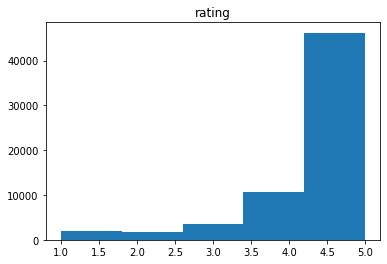

In [ ]:
electronics_rating.hist(column="rating",grid=False,bins=5)

# Create user_id and item_id columns - Ming Lu

In [ ]:
# Create indices df for user and item lists
user_list = pd.DataFrame(electronics_rating.user.unique(),columns=["user"]).reset_index().rename(columns={"index":"user_index"})
item_list = pd.DataFrame(electronics_rating.item.unique(),columns=["item"]).reset_index().rename(columns={"index":"item_index"})

In [ ]:
# Add user_id and item_id columns to the df
electronics_rating = electronics_rating.merge(user_list,on='user')
electronics_rating = electronics_rating.merge(item_list,on='item')

In [ ]:
electronics_rating.head()

,item,user,rating,timestamp,user_index,item_index
0,B00001P4ZH,A2VFN33XFSDW9C,4.0,2017-08-11,0,0
1,B00001P4ZH,A19MJFMEE3035J,2.0,2017-03-18,1,0
2,B00001P4ZH,A1R42G8S6JIOEI,5.0,2017-01-24,2,0
3,B00001P4ZH,ABMF4UC4Z00NT,2.0,2016-09-12,3,0
4,B00001P4ZH,A2WJOOZA5T2KQ5,1.0,2016-05-07,4,0


# Split train and test data - Ming Lu

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(electronics_rating, test_size=0.2, random_state=42, stratify=electronics_rating.user)

In [ ]:
# Validate both datasets contains the same users
train.user.unique().shape[0],test.user.unique().shape[0]

(4963, 4963)

## 2. Build similarity function to calculate distance between users - *Jennifer Tsou*

In [ ]:
# KNN model with cosine
from sklearn.neighbors import NearestNeighbors
n_users = electronics_rating.user.unique().shape[0]
n_items = electronics_rating.item.unique().shape[0]

In [ ]:
# create user-item matrix for training dataset
# Ming - I updated the for loop to generate the matrix using the user_id and item_id
data_matrix_train = np.zeros((n_users, n_items))
for line in train.itertuples():
    data_matrix_train[line[5], line[6]] = line[3]

In [ ]:
# create user-item matrix for testing dataset
data_matrix_test = np.zeros((n_users, n_items))
for line in test.itertuples():
    data_matrix_test[line[5], line[6]] = line[3]

In [ ]:
# calculate similarity
from sklearn.metrics.pairwise import pairwise_distances 
user_similarity = pairwise_distances(data_matrix_train, metric='cosine')
item_similarity = pairwise_distances(data_matrix_train.T, metric='cosine')

## 3. Build function to make predictions based on similarity - *Jennifer Tsou*

In [ ]:
# build function to make predictions based on similarity
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred


In [ ]:
# make prediction on training data
user_prediction = predict(data_matrix_train, user_similarity, type='user')
item_prediction = predict(data_matrix_train, item_similarity, type='item')
# make prediction on testing data
#user_prediction = predict(data_matrix_test, user_similarity, type='user')
#item_prediction = predict(data_matrix_test, item_similarity, type='item')

In [ ]:
# Computing total mean squared error
def mse(data_matrix,prediction):
    xs, ys = data_matrix.nonzero()
    error = 0
    for x, y in zip(xs, ys):
        error += pow(data_matrix[x, y] - prediction[x, y], 2)
    return np.sqrt(error)

In [ ]:
MSE_user = mse(data_matrix_test, user_prediction)
MSE_item = mse(data_matrix_test, item_prediction)
print('MSE_user: ', MSE_user)
print('MSE_item: ', MSE_item)

MSE_user:  510.8944645208593
MSE_item:  516.8892642813942


## 4. Build utility functions for training the models - MSE, SGD, etc. - *Ming Lu*

In [ ]:
# Full user rating-item matrix
def full_matrix(b,user_bias,item_bias,P,Q):
    return b + user_bias[:,np.newaxis] + item_bias[np.newaxis:,] + P.dot(Q.T)

In [ ]:
# Ratings for user i and item j
def get_rating(b,user_bias,item_bias,P,Q,i,j):
    prediction = b + user_bias[i] + item_bias[j] + P[i, :].dot(Q[j, :].T)
    return prediction

In [ ]:
# Stochastic gradient descent to get optimized P and Q matrix
def sgd(b,user_bias,item_bias,P,Q,samples,alpha,beta):
    # alpha – Learning rate for stochastic gradient descent
    # beta – Regularization parameter for bias
    
    for i, j, r in samples:
        prediction = get_rating(b,user_bias,item_bias,P,Q,i,j)
        e = (r - prediction)

        # Update the bias terms and P & Q matrices
        user_bias[i] += alpha * (e - beta * user_bias[i])
        item_bias[j] += alpha * (e - beta * item_bias[j])

        P[i, :] += alpha * (e * Q[j, :] - beta * P[i,:])
        Q[j, :] += alpha * (e * P[i, :] - beta * Q[j,:])
    return user_bias, item_bias, P, Q

## 5. Build training function - *Jonhua Qin*

In [ ]:
def train_model(data_matrix, K, alpha, beta, iterations=100):
    # data_matrix – The user-item rating matrix 
    # K – Number of latent features
    # iterations – Number of iterations to perform stochastic gradient descent
    
    # Define number of user and items
    n_users = data_matrix.shape[0]
    n_items = data_matrix.shape[1]
    
    # Initializing user-feature (P) and item-feature (Q) matrix 
    P = np.random.normal(scale=1./K, size=(n_users, K))
    Q = np.random.normal(scale=1./K, size=(n_items, K))

    # Initialize bias terms
    user_bias = np.zeros(n_users)
    item_bias = np.zeros(n_items)
    b = np.mean(data_matrix[np.where(data_matrix != 0)])
    
    # Define list of training samples
    samples = [
    (i, j, data_matrix[i, j])
    for i in range(n_users)
    for j in range(n_items)
    if data_matrix[i, j] > 0
    ]
    
    # Stochastic gradient descent for given number of iterations
    training_process = []
    for i in range(iterations):
        np.random.shuffle(samples)
        user_bias, item_bias, P, Q = sgd(b,user_bias,item_bias,P,Q,samples,alpha,beta)
        prediction = full_matrix(b,user_bias,item_bias,P,Q)
        error = mse(data_matrix,prediction)
        training_process.append((i, error))
        if (i+1) % 20 == 0:
            print("Iteration: %d ; error = %.4f" % (i+1, error))

    return training_process,b,user_bias,item_bias,P,Q

## 6. Make predictions using the model - *Jonhua Qin*

In [ ]:
# predict the missing ratings with alpha = 0.001, beta=0.01, K=20
training_process,b,user_bias,item_bias,P,Q = train_model(data_matrix_train, K=20, alpha=0.001, beta=0.01, iterations=100)

Iteration: 20 ; error = 199.4380
Iteration: 40 ; error = 192.3041
Iteration: 60 ; error = 187.6527
Iteration: 80 ; error = 184.2580
Iteration: 100 ; error = 181.4742


In [ ]:
# predict the missing ratings with alpha = 0.001, beta=0.01, K=50
training_process_2,b_2,user_bias_2,item_bias_2,P_2,Q_2 = train_model(data_matrix_train, K=50, alpha=0.001, beta=0.01, iterations=100)

Iteration: 20 ; error = 199.6648
Iteration: 40 ; error = 192.7936
Iteration: 60 ; error = 188.4594
Iteration: 80 ; error = 185.4842
Iteration: 100 ; error = 183.2813


In [ ]:
# predict the missing ratings with alpha = 0.01, beta=0.01, K=20
training_process_3,b_3,user_bias_3,item_bias_3,P_3,Q_3 = train_model(data_matrix_train, K=20, alpha=0.01, beta=0.01, iterations=100)

Iteration: 20 ; error = 163.4672
Iteration: 40 ; error = 98.3780
Iteration: 60 ; error = 57.0105
Iteration: 80 ; error = 37.9154
Iteration: 100 ; error = 28.3092


In [ ]:
# predict the missing ratings with alpha = 0.001, beta=0.1, K=20
training_process_4,b_4,user_bias_4,item_bias_4,P_4,Q_4 = train_model(data_matrix_train, K=20, alpha=0.001, beta=0.1, iterations=100)

Iteration: 20 ; error = 199.6858
Iteration: 40 ; error = 192.8633
Iteration: 60 ; error = 188.6084
Iteration: 80 ; error = 185.7383
Iteration: 100 ; error = 183.6894


In [ ]:
# predict the missing ratings with alpha = 0.005, beta=0.01, K=20
training_process_5,b_5,user_bias_5,item_bias_5,P_5,Q_5 = train_model(data_matrix_train, K=20, alpha=0.005, beta=0.01, iterations=100)

Iteration: 20 ; error = 181.4399
Iteration: 40 ; error = 163.8237
Iteration: 60 ; error = 132.6573
Iteration: 80 ; error = 100.4325
Iteration: 100 ; error = 75.6433


Convert the best model into prediction matrix

In [ ]:
# Round the predictions to integer ratings
prediction_1 = np.around(full_matrix(b,user_bias,item_bias,P,Q),0)
MSE_1 = mse(data_matrix_test, prediction_1)
print(MSE_1)

103.40212763768452


In [ ]:
# Round the predictions to integer ratings
prediction_2 = np.around(full_matrix(b_2,user_bias_2,item_bias_2,P_2,Q_2),0)
MSE_2 = mse(data_matrix_test, prediction_2)
print(MSE_2)

103.30053242844394


In [ ]:
# Round the predictions to integer ratings
prediction_3 = np.around(full_matrix(b_3,user_bias_3,item_bias_3,P_3,Q_3),0)
MSE_3 = mse(data_matrix_test, prediction_3)
print(MSE_3)

112.26753760548951


In [ ]:
# Round the predictions to integer ratings
prediction_4 = np.around(full_matrix(b_4,user_bias_4,item_bias_4,P_4,Q_4),0)
MSE_4 = mse(data_matrix_test, prediction_4)
print(MSE_4)

103.39245620450265


In [ ]:
# Round the predictions to integer ratings
prediction_5 = np.around(full_matrix(b_5,user_bias_5,item_bias_5,P_5,Q_5),0)
MSE_5 = mse(data_matrix_test, prediction_5)
print(MSE_5)

106.91585476438937


In [ ]:
training_process = np.array(training_process)
training_process_2 = np.array(training_process_2)
training_process_3 = np.array(training_process_3)
training_process_4 = np.array(training_process_4)
training_process_5 = np.array(training_process_5)

Validate the prediction results with the test dataset - **to be completed**

## 7. Visualize Results - *Ming Lu*

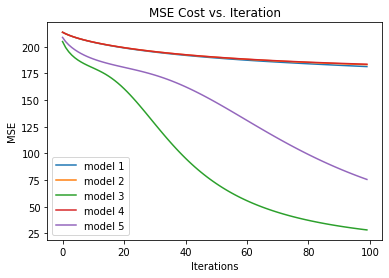

In [ ]:
plt.plot(training_process[:,0],training_process[:,1],label="model 1")
plt.plot(training_process_2[:,0],training_process_2[:,1],label="model 2")
plt.plot(training_process_3[:,0],training_process_3[:,1],label="model 3")
plt.plot(training_process_4[:,0],training_process_4[:,1],label="model 4")
plt.plot(training_process_5[:,0],training_process_5[:,1],label="model 5")
plt.title("MSE Cost vs. Iteration")
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.legend()
plt.show()